### Note/PitchContour Segmentation 

Segmenting Notes directly from the postprocessed pitch track by grouping and averaging tracks. 
 
The implementation uses PitchMelodia and PitchContourSegmentation Essentia functions. The pitch sequences estimated from two audio signals are converted into a set of discrete note events. Each note is defined by its onset time, duration and MIDI pitch value. The main object is to compare the Pitch values of PitchMelodia algorithm and MIDIpitch values of PitchContourSegmentation algoritm.

#### Segmentation of the pitch series:

R. J. McNab et al., "Signal processing for melody transcription," in Proc. Proc. 19th Australasian Computer Science Conf., 1996

Frames are grouped from left to right.A frame whose frequency within 50cents  of the average of the growing segment is included in the average. Any segments longer than 100ms is considered as a note.
For the purpose of determining note durations, notes are extended first by incorporating any contiguous short segments on the right until encountering a change in direction of frequency gradient, unvoiced segments or another note. These newly incorporated segments are considered transitional regions-their frequency estimates are not modified. Notes are then similarly extended on the left.

  Prepared by Ceren Can, Feb. 2018



### Import Modules and declaration of Some Variables:

In [1]:
import freesound,sys,os
import urllib.request
import essentia.standard as ess
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from scipy.fftpack import fft
from scipy.signal import get_window
import matplotlib.patches as mpatches

#sounds directory
soundsDir='../../data/noteSegmentation/'

fs = 44100
windowSize=2048
windowFunction='hann'
hopSize=1024
#t=np.arange(fs)/float(fs)
maxFrequency=2000
minFrequency=50
fftN=2048
wavFileNames=['flute.wav','guitar.wav']
#initialise a list to keep my dictionary datas
dataList=[]



### Download Sounds from Freesound:

In [2]:
# https://freesound.org/people/Zabuhailo/sounds/145514/
# https://freesound.org/people/guitarguy1985/sounds/52082/

client = freesound.FreesoundClient()
your_api_key = "...yourApiKeyGoesHere..."
client_id = "...yourTokenIDgoesHere..."
client.set_token(your_api_key,"token")

if not os.path.isdir(soundsDir):
    os.mkdir(soundsDir)

if not os.path.isfile(soundsDir+"/flute.wav"):
    fluteFreesound = client.get_sound(145514)
    fluteFreesound.retrieve_preview(soundsDir, name="flute.wav")    

if not os.path.isfile(soundsDir+"/guitar.wav"):
    guitarFreesound = client.get_sound(52082)
    guitarFreesound.retrieve_preview(soundsDir, name="guitar.wav") 

### Define the functions:

In [3]:
#creating a function to read the files and store them in fileData dictionary
def readwawFiles(file,fs): 

    fileName = os.path.join(soundsDir, file)
    fileData=initiateData4File(file,soundsDir)
    #load the file
    x = ess.MonoLoader(filename = fileName, sampleRate = fs)()  
    #apply equalLoudness with essentia
    x = ess.EqualLoudness()(x)
    return x


#creating dictionary to store the returned parameters from segmentation 
def initiateData4File(file,soundsDir):
     
    fileData=dict();fileData['name']=file.split('.')[0];fileData['path']=soundsDir;
    fileData['duration']=[]; 
    fileData['onset']=[];
    fileData['MIDIpitch']=[];
    return fileData

### Call Essentia Functions:

In [4]:
#obtaining pitch by using Essentia Pitch Melodia
def PredominantPitch(x,fs,windowSize,hopSize):
    run_predominant_melody = ess.PitchMelodia(guessUnvoiced=True,
                                      frameSize=windowSize,
                                      hopSize=hopSize,
                                      maxFrequency=2000,
                                      minFrequency=50,
                                      sampleRate=fs);
    
    pitch, _ = run_predominant_melody(x)
    return pitch

def getSegmentationElements(soundsDir,file,windowSize,hopSize,fs,pitch,x,fileData):

    onset, duration, midipitch= ess.PitchContourSegmentation(sampleRate = fs,hopSize=hopSize,minDuration=0.2)(pitch,x)
        
    fileData['duration'].append(duration)
    fileData['onset'].append(onset)
    fileData['MIDIpitch'].append(midipitch)
    dataList.append(fileData)
    
    return dataList


In [5]:
#Converts Midi Values to and creates and F0 list
def miditoF0(midiValues,duration):
    #creating an empty array
    newF0List=[]
    #range: 0 to the duration(comes from pitchcontoursegmentation)
    for i in range(0,len(duration)):
        # ex= np.floor(-2.5) == -3.
        for j in range(0,int(np.floor(duration[i]*44100))):
            #A4 reference note, set at 440 Hz,
            #69 midi number of A4
            #midi-69 gives the semitones for the octaves below A4
            #dividing semitones and multplying to 12 gives the frequencies
            f0=2**((midiValues[i]-69)/12)*440
            #add to the list
            newF0List.append(f0)
    return newF0List

In [6]:
#to draw spectogram - creating and returning mX
def calculateMagnitudeSpectrum(x,fftN,windowFunction,windowSize,hopSize):

    def logMagnitude(x_win):
        #computing fft
        X=fft(x_win,fftN)
        #taking 1/25 of the spectrum and its magnitude
        absX=np.abs(X[:int(fftN/25)])
        #deleting zeros
        absX[absX<np.finfo(float).eps]=np.finfo(float).eps
        return 20*np.log10(absX)
    
    #window function scipy
    w = get_window(windowFunction, windowSize)
    startIndexes=np.arange(0, x.size-windowSize,hopSize, dtype=int)
    numWindows=startIndexes.size
    #creating an empty array
    mX = np.array([]).reshape(0,int(fftN/25))
    for k in range(numWindows):
        startInd=startIndexes[k]
        x_win=x[startInd:startInd+windowSize]*w
        #Stack arrays in sequence vertically
        mX = np.vstack((mX,logMagnitude(x_win)))

    return mX


### Plotting:

In [7]:
def plot (x, fs, pitch, midiValues,onsetValues,hopSize,mX,newf0List):
    
    # create a subplot 3x1 with size 20,15
    f, axarr = plt.subplots(3,1,figsize=(20,15))
    
    #plotting signals with onset times
    t=np.arange(len(x))/float(fs)
    axarr[0].plot(t,x)
    axarr[0].set_title('Detected Onsets with PitchContourSegmentation Function - File: '+file)
    axarr[0].axis('off')
    axarr[0].vlines(onsetValues, -1, 1, color='r',linestyle = "--", linewidth=1.0)
   
    #f0 PitchMelodia
    xPitch=np.arange(len(pitch))
    #linspace:to make equal the size of new 0list's x axis with our pitch len
    xnewF0List=np.linspace(0,len(pitch),len(newf0List))
    
    #Plotting the spectrogram(matrix)
    timeAxSec=np.arange(mX.shape[0])*hopSize/float(fs)
    #Normalizing frequency axis
    freqAx_normalized=np.arange(mX.shape[1])/float(fftN)
    freqAxHz=float(fs)*freqAx_normalized
    
    axarr[1].pcolormesh(timeAxSec,freqAxHz,np.transpose(mX))
    #fit
    axarr[1].set_xlim([0,timeAxSec[-1]])
    axarr[1].set_ylim([0,freqAxHz[-1]])
    axarr[1].set_title('Spectrogram '+file)
    axarr[1].set_ylabel('frequency(Hz)')
    axarr[1].set_xlabel('time(seconds)')
    axarr[1].plot(xPitch/float(fs)*hopSize,pitch,'r',label='Pitch Detected from PitchMelodia ')
    axarr[1].legend(loc=1)
    
    #plot3
    axarr[2].plot(xPitch/float(fs)*hopSize,pitch,'c',label='Pitch Detected from PitchMelodia')
    axarr[2].legend(loc=1)
    axarr[2].plot(xnewF0List/float(fs)*hopSize,newf0List,'m',label='MIDIPitch Detected from PitchContourSegmentation')
    axarr[2].legend(loc=1)
    axarr[2].set_title('Pitch Comparison')
    
    #to avoid tittle overlap 
    f.tight_layout()
    plt.show()


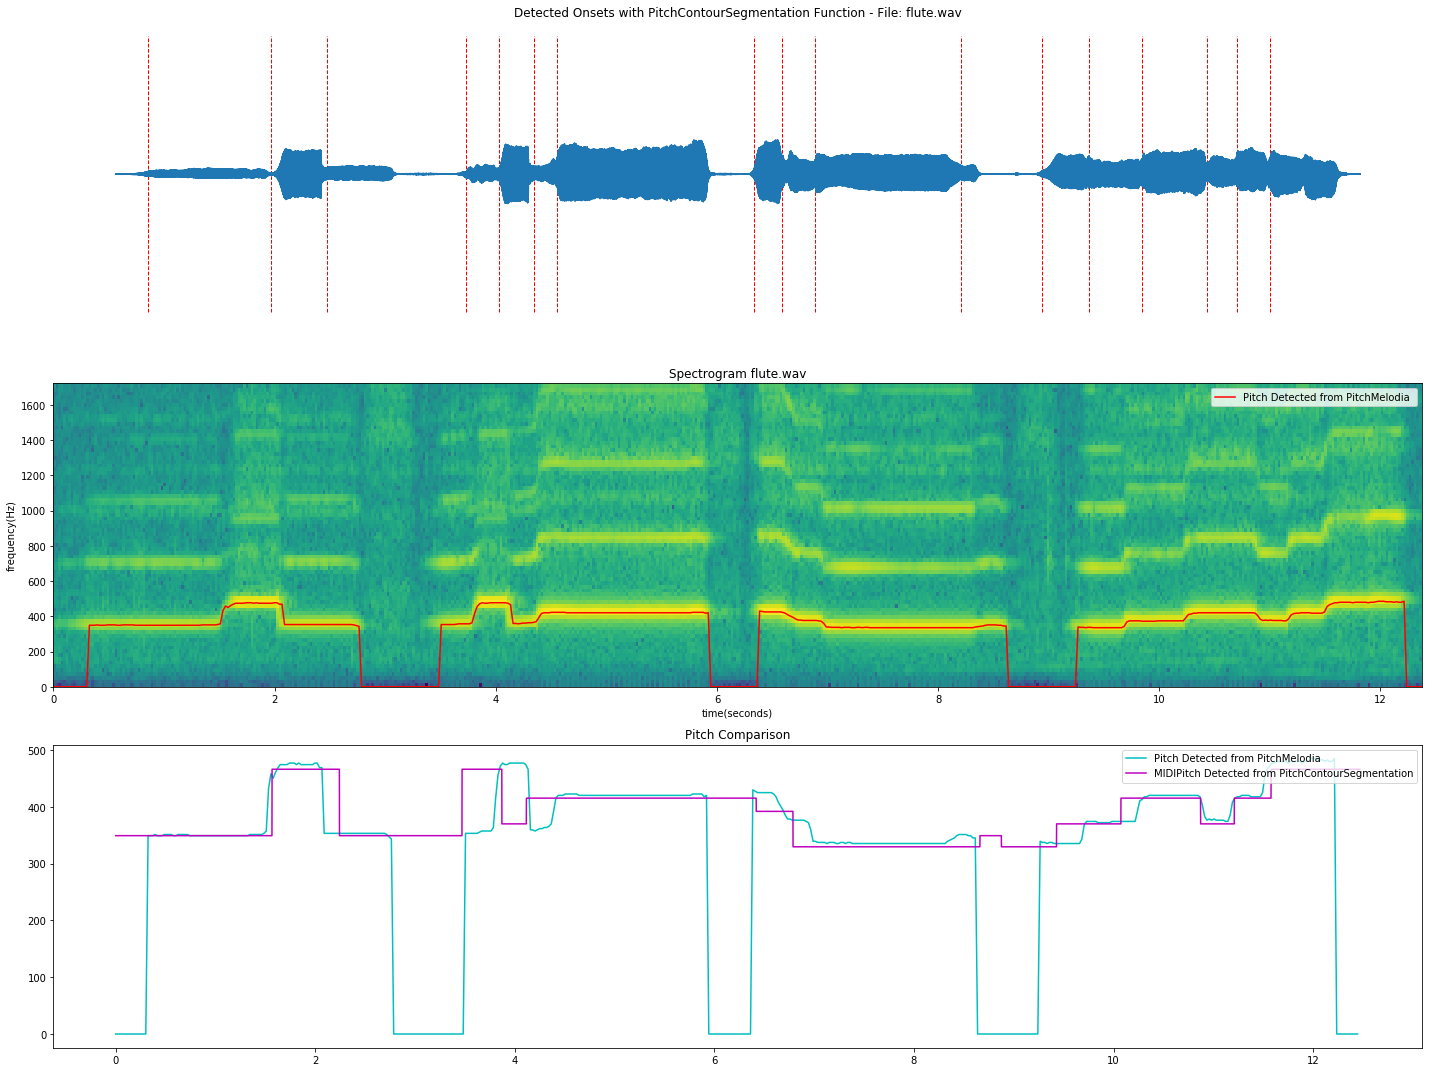

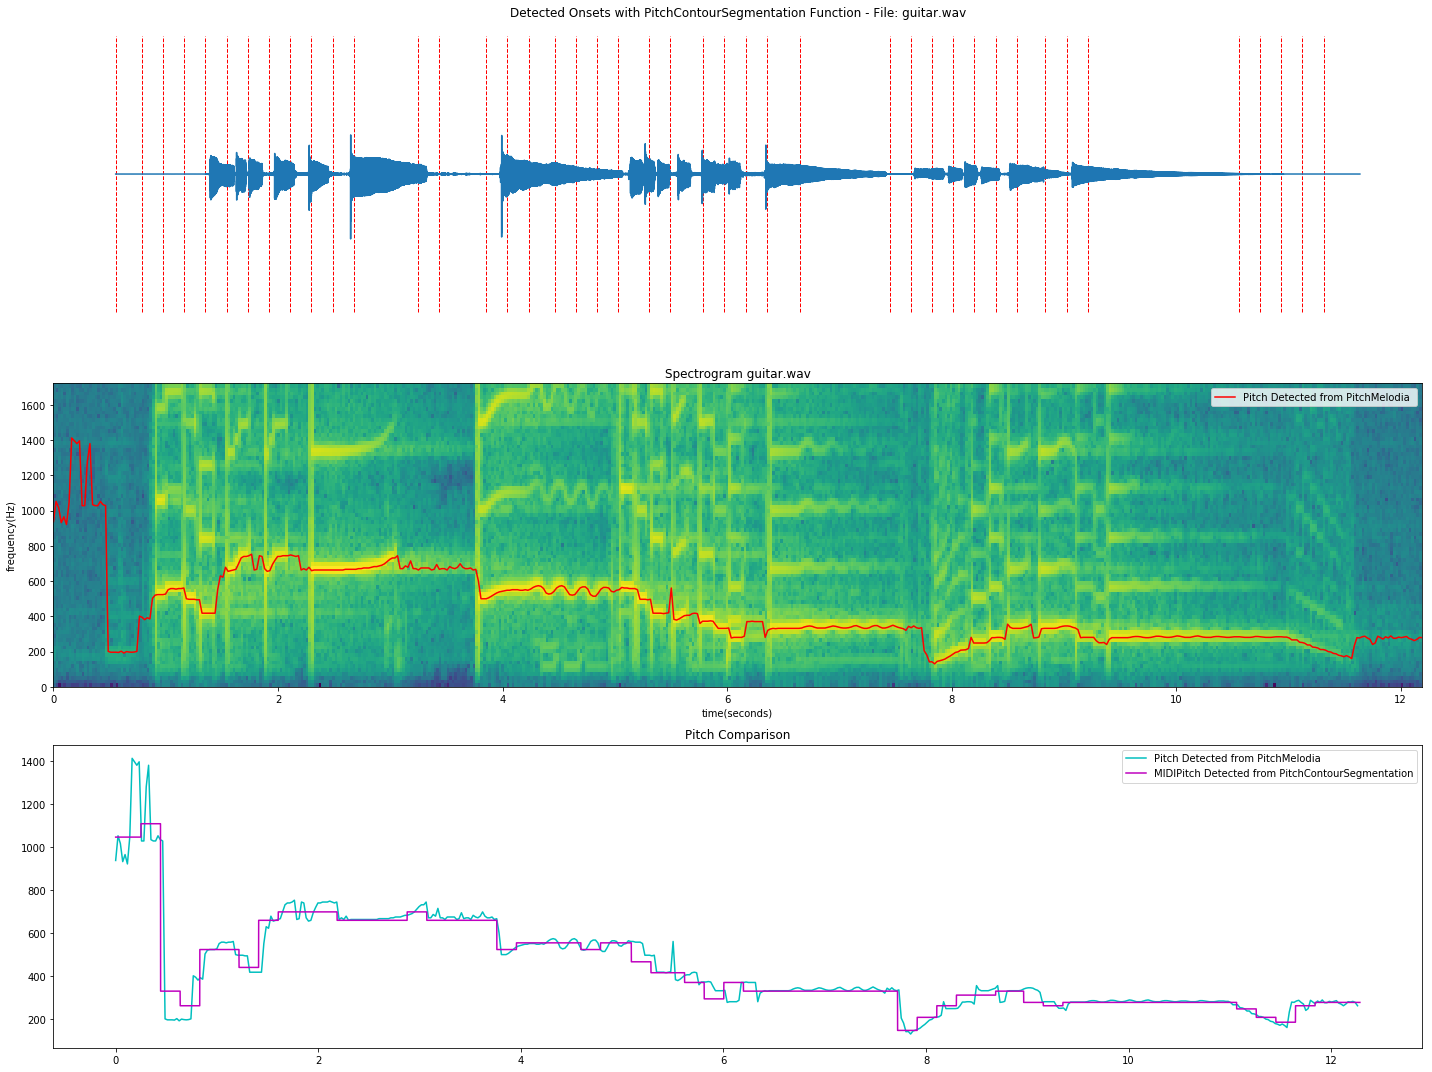

In [8]:
#iterate through the file names from the array of sounds names
for file in wavFileNames:

    #read file
    x=readwawFiles(file,fs)
    
    #get pitch
    pitch= PredominantPitch(x, fs,windowSize,hopSize)
    
    #save the data to fileData dic
    fileData=initiateData4File(file,soundsDir)
    
    #append dic elements to the dataList after applying segmentation
    dataList = getSegmentationElements(soundsDir,file,windowSize,hopSize,fs,pitch,x,fileData)
    
    #for plot function
    mX= calculateMagnitudeSpectrum(x,fftN, windowFunction,windowSize,hopSize)
    
    midiValues=dataList[0]['MIDIpitch']
    onsetValues=dataList[0]['onset']
    duration=dataList[0]['duration']
    
    #create a new F0list by using midiValues and the duration of pitchcontoursegmentation
    #to compare Pitch values for each algorithm
    newF0List=miditoF0(midiValues[0],duration[0])
    
    #call plot function
    plot(x,fs,pitch,midiValues,onsetValues,hopSize,mX,newF0List)
    
    #clear datalist for the next file
    dataList.clear()
